# **Assignment 4**

Cory Melendez

### Background:
One of the most coveted types of prediction, maybe only second to knowing the lottery numbers, is that of the stock market. Stock traders, that is Non HFT/algo traders, will typically look to tools such as quantitative analysis (QA). They attempt to detect patterns that arise from human behavior, believed to be unchanging. This project instead attempts to use ML models in order to build up a scientifically more sound method than methods such as QA that can predict how the market will move in the very short term.

One of the challenges to this project, and will require further research, is to identity not only if our model will have an acceptable accuracy using the data below, but why. Markets are ever-changing, and are constantly affected not only by geoeconomic events, but geopolitical events as well. Identifying the circumstances where it *could* work and *when* it could work is just as important as building the model itself. We found paper 1, which goes over how researchers used this dataset, and paper 2, a summary of 100 published articles, to be a good starting point in understanding what we will call the 'reproducability' problem as well as understanding how to build our models better.

The last challenge is the size of the data, I'll be trimming the number of columns not only to stay under the column limit, but to better narrow down and understand the factors that contribute to the output.



### Project Description: 
This project's main aim is to output a binary classificiation that will be able to tell a theoritical day trader whether or not they should buy and sell a stock on a certain day.This project will use data from link below in order to build our ML models. We will also refer to the paper below in order for not only reference on how a model can be built, but to also refer to it for understanding the domain.

Our main methodology will be to groom the data into something that is digestible by the model. Since our aim is to only output a binary classification (yes/no), the question we will be asking our model is 'should i buy the stock at close today and sell at close of tomorrow'. This simple strategy will simplify the model greatly, but will require restructuring the data and creating a target column that our model predicts.

Our simple goals that define success is as follows: Can we beat not entering the market at all (not investing)? Can our model beat a trading algorithm that simply randomly outputs yes/no? A goal beyond that would be to answer: What other non-ML algorithms, in the same time and circumstances, can our model beat?


Data: https://archive.ics.uci.edu/ml/datasets/CNNpred%3A+CNN-based+stock+market+prediction+using+a+diverse+set+of+variables

Paper: https://reader.elsevier.com/reader/sd/pii/S0957417419301915?token=746C33D1046F2DDA4EE614C2A4606AF2260493F0DC652081FF1F03968E01DC023369A293A638CEE35E24DB8BB7EE1259&originRegion=us-east-1&originCreation=20230119051158

Paper 2: https://reader.elsevier.com/reader/sd/pii/S0957417421009441?token=EEE8A8BF467B1370F99F73C46DC7AD74D88F0AB17AC08F5137A3B16E14E69D382DE8A689EF492C09E0CF67690D289807&originRegion=us-east-1&originCreation=20230119052216

### Performance Metric: 

Our metric will be pretty simple, given any trade, or a group of trades, advised by the model, is: 

(current price - bought price ) * X > X * epsilon, where X is the amount of money that was invested and epsilon is any arbitrary small positive number

 
If this statement is true, then our model has outperformed our money not entering the market at all by an arbitrary small number.

Furthermore, 

does:

Sum(MLProfit) > Sum(RandomProfit) * epsilon

Where Sum(MLProfit) is the profit made from a arbitrary number of trades using our ML model greater, and Sum(RandomProfit) is the profit madae from an arbitrary number of trades using a random output algorithm, and epsilon is an arbitrary small number

If so, then we have beaten randomness by a factor of epsilon and have met our main objective.





### Setup Notebook

In [505]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as skl
import matplotlib.pyplot as plt
from typing import List, Dict
from datetime import datetime
from numpy.random import randint
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import config_context
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression



In [506]:
dji_file = 'Processed_DJI.csv'
nasdaq_file = 'Processed_NASDAQ.csv'
nyse_file = 'Processed_NYSE.csv'
russel_file = 'Processed_RUSSELL.csv'
sp_file = 'Processed_S&P.csv'

dji_df = pd.read_csv(dji_file)
nasdaq_df= pd.read_csv(nasdaq_file)
nyse_df = pd.read_csv(nyse_file);
russel_df = pd.read_csv(russel_file);
sp_df = pd.read_csv(sp_file);


### Data Cleaning and Feature Transformers
Combine, remove, and create columns to give our model a better context for each trading day and how the market reacted on previous' days

In [507]:
#GLOBALS
random_seed = 42
OIL= "Oil"
GOLD="Gold"
XOM="XOM"
JPM="JPM"
GE="GE"
JNJ="JNJ"
WFC="WFC"
AMZN="AMZN"
MSFT = "MSFT"

STOCK_COLS: List[str] = [
    OIL, GOLD, XOM, JPM, GE, JNJ, WFC, AMZN, MSFT
]

DTB4WK = "DTB4WK"
DTB3 = "DTB3"
DTB6 = "DTB6"
DGS5 = "DGS5"
DGS10 = "DGS10"


TREASURY_COLS: List[str] = [
    DTB4WK, DTB3, DTB6, DGS5, DGS10
]

STOCKS_BY_INDUSTRY: Dict[str, str] = {
    OIL: 'oil & gas',
    GOLD: 'industrial metal',
    XOM: 'oil & gas',
    JPM: 'banking',
    GE: 'industrial machinery',
    JNJ: 'drugs',
    WFC: 'banking',
    AMZN: 'tech',
    MSFT: 'tech'
}
#['oil & gas', 'industrial metal', 'Banking', 'industrial machinery', 'drugs', ]
COMMON_COLS: List[str] = [
    'Date', 'Close', 'Volume', 
    #Add this for convenience
    'Name'
] + TREASURY_COLS + STOCK_COLS

#columns that need to be calculated
CALC_COLS = [
    #dow jones
    'DJI',
    # ny stock exchang
    'NYSE', 
    #russel
    'RUSSEL', 
    #s&p 500
    'GSPC', 
    #nasdaq
    'IXIC'
]

ALL_DFS: List[pd.DataFrame] = [dji_df, nasdaq_df, nyse_df, russel_df, sp_df]

## Preprocessing Pipeline

In [508]:
#calculate the rate of change from the previous two days and drop the first day
class DateToQuarterTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_ = X.copy()

    X_['Date'] = pd.to_datetime(X_['Date'])
    # for i in range(0, len(X_)):
    #   month = X_.loc[i, 'Date'].month

    #   if 1 <= month <= 3:
    #     X_.loc[i, 'Quarter'] = 1;
    #   elif 4 <= month <= 6:
    #     X_.loc[i, 'Quarter'] = 2;
    #   elif 7 <= month <= 9:
    #     X_.loc[i, 'Quarter'] = 3
    #   else:
    #     X_.loc[i, 'Quarter'] = 4

    X_['DayOfWeek'] = X_['Date'].dt.dayofweek
    X_['Month'] = X_['Date'].dt.month
    X_['Year'] = X_['Date'].dt.year
    X_['Day'] = X_['Date'].dt.day

    X_.drop(columns=['Date'], inplace=True)

    return X_

class DateTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self;
  
  def transform(self, X, y=None):
    X_=X.copy()
    X_['Date'] = pd.to_datetime(X_['Date'])
    X_['Year'] = X_['Date'].dt.year
    X_['Month'] = X_['Date'].dt.month;
    X_['DayOfMonth'] = X_['Date'].dt.day;
    X_['DayOfWeek'] = X_['Date'].dt.dayofweek

    X_.drop(columns=['Date'], inplace=True)
    return X_

class TrimUnusedColumnsTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, keepColumns: List[str]):
    self.keepColumns: List[str] = keepColumns
  
  def fit(self, X, y=None):
    return self;

  def transform(self, X, y=None):
    X_ = X.copy()
    X_ = X_[self.keepColumns]
    return X_

class RenameCloseVolumeColumnsTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self;

  def transform(self, X, y=None):
    X_=X.copy()
    exchangeName = X.loc[0, 'Name']
    return X_.rename(columns={'Close': f'{exchangeName}_Close', 'Volume': f'{exchangeName}_Volume'})

class TreasuryRateTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, targetTreasury: str, backNumberOfDays: int):
    self.targetTreasury: str = targetTreasury;
    self.backNumberOfDays: int = backNumberOfDays

  def fit(self, X, y=None):
    return self;

  def transform(self, X, y=None):
    X_= X.copy()

    for i in range(self.backNumberOfDays, len(X)):
        X_.loc[i, f'{self.targetTreasury}_Last_{self.backNumberOfDays}_Yield_Change'] = X_.loc[i, self.targetTreasury] - X_.loc[i - self.backNumberOfDays, self.targetTreasury]

    return X_   

class DaysBackRateTransformer(BaseEstimator, TransformerMixin): 

  def __init__(self, targetStock: str, numberOfDays: int):
    self.targetStock: str = targetStock
    self.numberOfDays: int = numberOfDays

  def fit(self, X, y=None):
    return self;

  def transform(self, X, y=None):
    X_ = X.copy()
    return self.addTargetStockDayRate(X_, self.targetStock)

  def addTargetStockDayRate(self, X_: pd.DataFrame, stock: str):
    for i in range(self.numberOfDays, len(X_)):
      X_.loc[i, f'{stock}_-{self.numberOfDays}_DayRate'] = X_.loc[i - self.numberOfDays, stock]
    return X_


class TotalChangeOverDaysTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, overDays: int, targetStock: str):
    self.overDays = overDays
    self.targetStock = targetStock;

  def fit(self, X, y=None):
    return self;

  def transform(self, X, y=None):
    X_ = X.copy()
    return self.addTotalChange(X_, self.targetStock)
  
  def addTotalChange(self, X_: pd.DataFrame, stock: str):
    for i in range(self.overDays - 1, len(X_)):
      X_.loc[i, f'{stock}_TotalChange_Last_{self.overDays}_Days'] = self.phi(X_.loc[i-self.overDays + 1:i, stock].values.tolist())
    return X_;

  def phi(self, numbers):
    product = 1
    for n in numbers:
      mult = (1+n)
      if mult == 1:
        mult = 1

      product *= mult
    return product

class WouldProfitTargetTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, targetStock: str):
    self.targetStock = targetStock

  def fit(self, X, y=None):
    return self;

  def transform(self, X, y=None):
    X_=X.copy()
    for i in range(0, len(X)-1):
      if(X_.loc[i+1, f'{self.targetStock}'] > 0):
        X_.loc[i, f'{self.targetStock}_WouldProfit'] = 'invest'
      else:
        X_.loc[i, f'{self.targetStock}_WouldProfit'] = 'abstain'
    return X_

class AddExchangeCloseVolumeTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, source: pd.DataFrame):
    self.source = source

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_ = X.copy()
    exchangeName = self.source.loc[0,'Name']
    X_[f'{exchangeName}_Close'] = self.source[f'Close']
    X_[f'{exchangeName}_Volume'] = self.source[f'Volume']
    return X_

class SameIndustryDaysBackRateTransformer(DaysBackRateTransformer):
  def __init__(self, industryByStock: Dict[str, str], targetStock: str, numberOfDays: int):
    super().__init__(targetStock, numberOfDays)
    self.industryByStock = industryByStock

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_ = X.copy()
    targetStockIndustry = self.industryByStock[self.targetStock]

    for key in self.industryByStock:
      if(self.industryByStock[key] == targetStockIndustry and key != self.targetStock):
        X_ = self.addTargetStockDayRate(X_, key)

    return X_

class SameIndustryTotalChangeOverDaysTransformer(TotalChangeOverDaysTransformer):
  def __init__(self, industryByStock: Dict[str,str], overDays: int, targetStock: str):
    super().__init__(overDays, targetStock)
    self.industryByStock = industryByStock

  def fit(self, X, y=None):
    return self;
  
  def transform(self, X, y=None):
    X_ = X.copy()
    targetStockIndustry = self.industryByStock

    for key in self.industryByStock:
      if(self.industryByStock[key] == targetStockIndustry and key != self.targetStock):
        X_ = self.addTotalChange(X_, self.targetStock)

    return X_

class ExchangeVolumeChangeOverTime(BaseEstimator, TransformerMixin):
  def __init__(self, exchangeName: str, overDays: int):
    self.exchangeName = exchangeName
    self.overDays = overDays

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_ = X.copy()
    return self.addTotalChange(X)

  def addTotalChange(self, X_: pd.DataFrame):
    for i in range(self.overDays - 1, len(X_)):
      X_.loc[i, f'{self.exchangeName}_Volume_Change_Over_{self.overDays}_Days'] = self.phi(X_.loc[i-self.overDays + 1:i, f'{self.exchangeName}_Volume'].values.tolist())
    return X_;

  def phi(self, numbers):
    product = 1
    for n in numbers:
      product *= (1+n)
    return product

class ExchangeCloseRateChange(BaseEstimator, TransformerMixin):
  def __init__(self, exchangeName: str, overDays: int):
    self.exchangeName = exchangeName
    self.overDays = overDays

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_ = X.copy()

    for i in range(self.overDays, len(X_)):
      X_.loc[i, f'{self.exchangeName}_Close_Rate_Change_Over_{self.overDays}_Days'] = 1 - (X_.loc[i, f'{self.exchangeName}_Close'] / X_.loc[i-self.overDays, f'{self.exchangeName}_Close'])

    return X_

class FinalColCleanup(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X.drop(columns=['Name'], inplace=True)
    return X

class FeatureEngineeringPipelineConstants():
  def __init__(self, stockSymbols: List[str], treasurySymbols: List[str], common_cols: List[str], industryByStock: Dict[str,str]):
    self.stockSymbols: List[str] = stockSymbols
    self.treasurySymbols: List[str] = treasurySymbols
    self.commonColumns: List[str] = common_cols
    self.industryByStock: Dict[str, str] = industryByStock

class FeatureEngineeringPipelineConfig():
  def __init__(self, dataframes: List[pd.DataFrame], constants: FeatureEngineeringPipelineConstants, daysBack: List[int], targetStock: str):
    self.constants: FeatureEngineeringPipelineConstants = constants

    self.dataframes: List[pd.DataFrames] = dataframes
    self.targetStock: str = targetStock
    self.daysBack = daysBack

class FeatureEngineeringPipelineFactory():
  def __init__(self, config: FeatureEngineeringPipelineConfig):
    self.config = config

  def __createAddExchangeCloseVolumeTransformers(self):
    l = []

    for i in range(0, len(self.config.dataframes)):
      l.append((f'use_add_df{i}_exchange_transformer', AddExchangeCloseVolumeTransformer(self.config.dataframes[i])))

    return l

  def __createDaysBackRateTransformers(self): 
    l = []

    for stock in self.config.constants.stockSymbols:
      for n in self.config.daysBack:
        l.append((f'use_{n}_days_back_rate_transformer_{stock}', DaysBackRateTransformer(stock, n)))

    return l

  def __createExchangeCloseRateChange(self):
    l = []

    for df in self.config.dataframes:
      exchangeName = df.loc[0, 'Name']
      for n in self.config.daysBack:
        l.append((f'use_exchange_{exchangeName}_close_rate_over_{n}_days_transformer', ExchangeCloseRateChange(exchangeName, n)))

    return l

  def __createExchangeVolumeChangeOverTimeTransformers(self):
    l = []

    for df in self.config.dataframes:
      exchangeName = df.loc[0, 'Name']
      for n in self.config.daysBack:
        l.append((f'use_exchange_{exchangeName}_volume_change_over_{n}_days', ExchangeVolumeChangeOverTime(exchangeName, n)))
    
    return l

  def __createTotalChangeOverDaysTransformers(self):
    l = []

    days = self.config.daysBack
    for stock in self.config.constants.stockSymbols:
      for n in days:
        l.append((f'use_total_change_over_{n}_day_transformer_{stock}', TotalChangeOverDaysTransformer(n, stock)))

    return l
  def __createTreasuryYieldRateChangeTransformers(self):
    l = []

    for treasury in self.config.constants.treasurySymbols:
      for n in self.config.daysBack: 
        l.append((f'use_treasury_{n}_yield_rate_change_{treasury}', TreasuryRateTransformer(treasury, n)))
    
    return l

  def create(self) -> skl.pipeline.Pipeline:
    cleanupSteps = [
      ("use_trim_unused_columns_transformer", TrimUnusedColumnsTransformer(self.config.constants.commonColumns)),
      # ("use_date_transformer", DateTransformer()),
      ("use_date_to_quarter_transformer", DateToQuarterTransformer()),
      ("use_rename_close_volume_columns_tranformer", RenameCloseVolumeColumnsTransformer()),
    ] 

    addExchangeCloseVolumeTransformers = self.__createAddExchangeCloseVolumeTransformers() 

    exchangeCloseRateChangeTransformers = self.__createExchangeCloseRateChange()

    exchangeVolumeChangeOverTimeTransformers = self.__createExchangeVolumeChangeOverTimeTransformers()

    daysBackRateTransformers = self.__createDaysBackRateTransformers()

    totalChangeOverDaysTransformers = self.__createTotalChangeOverDaysTransformers()

    treasuryRateTransformer = self.__createTreasuryYieldRateChangeTransformers()

    targetTransformer = [('use_would_profit_target_transformer', WouldProfitTargetTransformer(self.config.targetStock))]

    finalCleanup = [('use_final_col_cleanup_transformer', FinalColCleanup())]

    pipelineSteps = cleanupSteps + addExchangeCloseVolumeTransformers + exchangeCloseRateChangeTransformers + exchangeVolumeChangeOverTimeTransformers + daysBackRateTransformers + totalChangeOverDaysTransformers + treasuryRateTransformer + targetTransformer + finalCleanup

    return Pipeline(
        steps=pipelineSteps
    )

class FeatureEngineeringPipelineFactoryFactory():
  def __init__(self, constants: FeatureEngineeringPipelineConstants, additionalExchangeDfs: List[pd.DataFrame]):
    self.additionalExchangeDfs = additionalExchangeDfs
    self.constants = constants

  def create(self, targetStock: str, numberOfBackDays: List[int]) -> FeatureEngineeringPipelineFactory:
    constants = FeatureEngineeringPipelineConstants(STOCK_COLS, TREASURY_COLS, COMMON_COLS, STOCKS_BY_INDUSTRY)
    config = FeatureEngineeringPipelineConfig(self.additionalExchangeDfs, constants, numberOfBackDays, targetStock)

    return FeatureEngineeringPipelineFactory(config)
  def createMany(self, targetStocks: List[str], numberOfBackDayCombinations: List[List[int]]) -> Dict[str, FeatureEngineeringPipelineFactory]:
    ret: Dict[str, FeatureEngineeringPipelineFactory] = {}

    for stock in targetStocks:
      for n in numberOfBackDayCombinations:
        ret[stock] = self.create(stock, n)
    
    return ret
  

In [509]:
constants = FeatureEngineeringPipelineConfig(STOCK_COLS, TREASURY_COLS, COMMON_COLS, STOCKS_BY_INDUSTRY)
initial_exchange = nyse_df
additional_exchange_dfs: List[pd.DataFrame] = [dji_df, nasdaq_df, russel_df, sp_df]

targetStocks: List[str] = STOCK_COLS + TREASURY_COLS
numberOfBackDayCombinations: List[List[int]] = [[1,2,3,5,10]]

factoryFactory = FeatureEngineeringPipelineFactoryFactory(constants, additional_exchange_dfs)
factories: Dict[str, FeatureEngineeringPipelineFactory] = factoryFactory.createMany(targetStocks, numberOfBackDayCombinations)

featureEngPipelines: Dict[str, skl.pipeline.Pipeline] = {}
for stock in targetStocks:
  featureEngPipelines[stock] = factories[stock].create()

### Example of resulting transformed dataset

Now from above, we have a set of pipelines in 'pipelines' that we can fit on our initial dataframe.

I went ahead and created multiple pipelines and datasets, where each one has a different target stock. The one I will be using moving forward will be microsoft stock.



### Feature Engineering

From the last assignment, these were the features we were planning on engineering, however, after the extensive transformations above, some have changed or be removed completly.

* Research our stock symbols and decide what industry they belong to, add a column indicating the industry. This will be later used for a one hot encode
  * Removed:
    * In our dataset, we dont have have sufficient number of stocks to warrant this. We only a few industries that had more than one stock.
    * We added transformers that calculate the rate change of all stocks across several days. The model should be able to derive which stocks are correlated on itself without adding data to signal what industry that stock is in.

* Since this project would normally use a time series approach, we'll want to add additional columns to get around this. Each row has to be indepedent of the previous rows, so we will add the return % of one or several of the previous days to simulate time series. Since in our business context, we are trading on behalf of a day trader, we dont have to add many of these columns
  * Added: Added multiple columns signaling the % change or the total change (phi of % changes that were in the dataset).

* We will drop all features that are not listed in our data_dictionary.csv as the first step in our pipeline

  * Removed some columns from our data_dictionary due to some innaccuracies in the paper that was supplied by the researchers. Not quite sure why, but Gas, Silver, & Copper were described to be in the datasets but were absent.

* We'll have to massage our data a little bit. We know that there are some columns whose data is repeated across the CSVs (like stock prices and commodoties) so we can extract that information from just one of the CSVs. Then, we'll want to transform the rest of the columns (ex: close/volume) into multiple columns, so we have NYSE_Close, NYSE_Volume, NASDAQ_Close, NASDAQ_Volume, etc., so we dont have multiple rows representing the same day
  * Added: The resulting transformer that we created in this notebook wasnt changed much from the original description.

* We'll also need to extract the return % of each stock exchange, the data is a little weird where the % return for a stock exchange x is not in that csv for x. Example: Nasdaq doesnt have the % return for the nasdaq but has NYSE, S&P, etc., we'll want to make sure all % returns our in our dataset.
  * This one was a little odd, but our originaly analysis was accurate to the resulting transformer that we needed in this notebook

* Further investigation is also needed to combine and average: 
  1. The % return of each stock exchange
    * Modified: Instead of combining or averaging, we added columns to give each row more context as to what the change in the Close price was over various amounts of days
  2. Volume
    * Modified: Instead of combining or averaging, we added columns to give each row more context as what the cumulative change over various days were
  3. Closing price
    * Modified: This was merged with #1
* Lastly, we'll want to transform the date column into something that we can sort by if needed. We can transform this column from a format 'mm-dd-yyyy' to a number yyyymmdd which will rank by year first, then month, then day
  * Modified: Instead of a date, we kept our index and split it across multiple columns (day, month, year, day of week). My thinking was that some traders would trade differently in different parts of the year, and even on different days of the week.

#### Final list of features

1. DateToQuarterTransformer: transform the date into a quarter, that we'll later use a oneHotEncoder on

2. TreasuryRateTransformer: get the rate of change for treasury rates using today and x days ago

3. DaysBackRateTransformer: put the rate of change from x amount of days ago for our stocks

4. TotalChangeOverDaysTransformer: get the total % of change over last x amount of days for all of our stocks

5. WouldProfitTargetTransformer: Add a target column by looking one day into the future to see if the stock went up

6. ExchangeVolumeChangeOverTime: calculate the % rate of change for volume for every exchagne

7. ExchangeCloseRateChange: calculate the % rate of change for Close price for every exchange.

#### EDA post processing

There wasnt a whole lot to be gathered from our EDA from our datasets without the feature engineering we have done in this notebook. But ill include what we did since there were some correlated columns that exist that we can remove along with their corresponding dervied feature columns.

In [510]:
class RemoveBadRowsTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_ = X.copy()
    X_ = X_.drop(X_.tail(1).index)
    X_ = X_.drop(X_.head(15).index)
    return X_ 

class RemoveHighlyCorrCols(BaseEstimator, TransformerMixin): 
  def __init__(self, aboveOrAt: float):
    self.aboveOrAt = aboveOrAt

  def fit(self, X, y=None):
    _corr = X.corr()
    #find the columns with the highest correlation values and remove
    _corr = _corr.abs()
    _sol = (_corr.where(np.triu(np.ones(_corr.shape), k=1).astype(bool))
                      .stack()
                      .sort_values(ascending=True))
    #find highly correlated features
    l: set = set()
    for index, value in _sol.items():
      if value >= self.aboveOrAt and index[0] != index[1]:
        if index[0] not in l:
          l.add(index[0])
    
    self.remove = list(l)

    return self

  def transform(self, X, y=None):
    X_ = X.copy()
    # _corr = X_.corr()

    # #find the columns with the highest correlation values and remove
    # _corr = _corr.abs()
    # _sol = (_corr.where(np.triu(np.ones(_corr.shape), k=1).astype(bool))
    #                   .stack()
    #                   .sort_values(ascending=True))
    
    # #find highly correlated features
    # l: set = set()
    # for index, value in _sol.items():
    #   if value >= self.aboveOrAt and index[0] != index[1]:
    #     if index[0] not in l:
    #       l.add(index[0])
    #     # if index[1] not in l:
    #     #   l.add(index[1])
    
    # remove = list(l)

    X_.drop(columns=self.remove, inplace=True)
    return X_
  
class ExcludeColsStandardScaler(BaseEstimator, TransformerMixin): 
    def __init__(self, excludeColumns: List[str], targetStock: str):
      self.excludeColumns = excludeColumns
      self.targetStock = targetStock
    
    def fit(self, X, y = None):
      performOnSet: set = set()
      for col in X.columns:
        if col not in self.excludeColumns:
          performOnSet.add(col)

      performOnList = list(performOnSet)
      X_ = X[performOnList]
      self.means = np.mean(X_, axis=0)
      self.stds = np.std(X_, axis=0) 

      return self

    def transform(self, X, y = None):
      exclude_cols = self.excludeColumns + [f'{self.targetStock}_WouldProfit']
      X_ = X.drop(columns=exclude_cols)

      X_ = (X_ - self.means) / self.stds

      for col in exclude_cols:
        X_[col] = X[col]

      return X_

class MyOneHotEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, oneHotEncoder: skl.preprocessing.OneHotEncoder):
    self.oneHotEncoder: skl.preprocessing.OneHotEncoder = oneHotEncoder
  
  def fit(self, X, y=None):
    self.oneHotEncoder.fit(X,y)
    return self
  
  def transform(self, X, y=None):
    return self.oneHotEncoder.transform(X)


In [511]:
#reconfigure pipelines
# cat_cols = ['DayOfWeek', 'Day', 'Month', 'Year']
cat_cols = []
pipelines: Dict[str, skl.pipeline.Pipeline] = {}
for stock in targetStocks:
  # cat_pipeline = Pipeline(steps=[('onehot_cat', MyOneHotEncoder(OneHotEncoder()))])
  # preproc = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols)], remainder='passthrough')



  pipe = Pipeline(steps=[
        ('feature_eng', featureEngPipelines[stock]),
        ('cleanup', RemoveBadRowsTransformer()), 
        ('use_standard_scalar', ExcludeColsStandardScaler(cat_cols, stock)),
        ('remove_corr_cols', RemoveHighlyCorrCols(float(.99))),
        # ('preproc', preproc), 
        # ('mdl', LogisticRegression(random_state=random_seed))
      ])
  pipelines[stock] = pipe

In [512]:
msft_df = pipelines[MSFT].fit_transform(initial_exchange)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\Cory\AppData\Local\Temp\ipykernel_67688\2081961601.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

In [513]:


msft_pipe = Pipeline(steps=[
  # ('prepared_data_pipeline', pipelines[MSFT]),
  ('mdl', LogisticRegression(random_state=random_seed))
])


## Hyperparameter Tuning

### LogisticRegression with Hyper-parameter Tuning

In [514]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

target = 'MSFT_WouldProfit'
X = msft_df.drop(columns=[target])
y = msft_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25, stratify=msft_df[target])
tuning_grid = {'mdl__l1_ratio': np.linspace(0,1,5),
               'mdl__C': np.logspace(-1,6,3)}

grid_search = GridSearchCV(msft_pipe, param_grid = tuning_grid, cv=5, return_train_score=True, n_jobs=-1)


In [515]:
tuning_grid

{'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06])}

In [516]:
grid_search.fit(X_train, y_train.values.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mdl',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06]),
                         'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             return_train_score=True)

In [517]:
print(grid_search.best_score_)
grid_search.best_params_

0.5047159871736143


{'mdl__C': 316.22776601683796, 'mdl__l1_ratio': 0.0}

In [518]:
from sklearn.metrics import classification_report

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

     abstain       0.48      0.48      0.48       244
      invest       0.49      0.49      0.49       248

    accuracy                           0.49       492
   macro avg       0.49      0.49      0.49       492
weighted avg       0.49      0.49      0.49       492



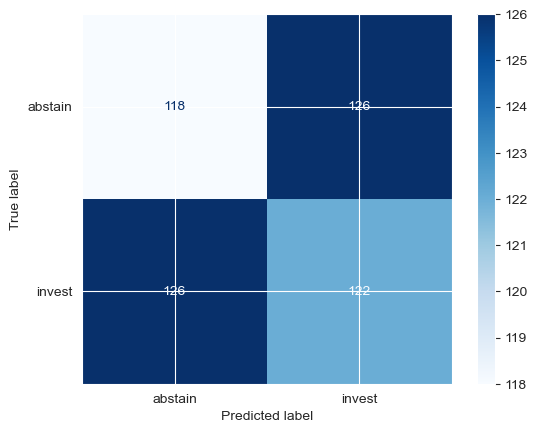

In [519]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DecisionTreeClassifier with Hyper-parameter Tuning

In [520]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
tuning_grid = {'criterion':['gini','entropy'],'max_depth':np.arange(3,15)}
grid_search = GridSearchCV(dtree, tuning_grid, cv=5)


In [521]:
tuning_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}

In [522]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [523]:
print(grid_search.best_score_)
grid_search.best_params_

0.500659642693541


{'criterion': 'gini', 'max_depth': 14}

In [524]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

     abstain       0.45      0.45      0.45       244
      invest       0.46      0.46      0.46       248

    accuracy                           0.46       492
   macro avg       0.46      0.46      0.46       492
weighted avg       0.46      0.46      0.46       492



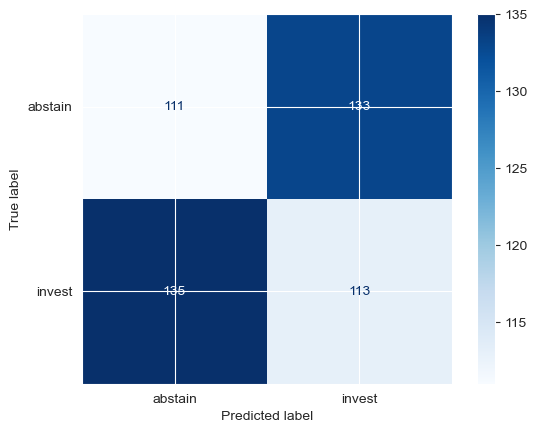

In [525]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### SVM with Hyper-parameter Tuning

In [526]:
from sklearn.svm import SVC
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [527]:
param_grid

{'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 'kernel': ['rbf']}

In [528]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [529]:
print(grid_search.best_score_)
grid_search.best_params_

0.49862116353641783


{'criterion': 'entropy', 'max_depth': 7}

In [530]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

     abstain       0.49      0.65      0.56       244
      invest       0.49      0.33      0.40       248

    accuracy                           0.49       492
   macro avg       0.49      0.49      0.48       492
weighted avg       0.49      0.49      0.48       492



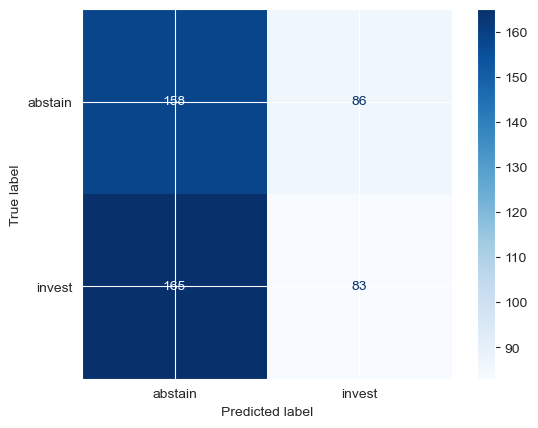

In [531]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

### KNN with Hyperparameter Tuning

In [532]:
from sklearn.neighbors import KNeighborsClassifier

knn_param_grid = {'leaf_size': list(range(1,50)),
              'n_neighbors': list(range(1,30))}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, knn_param_grid, cv = 10)


In [533]:
knn_param_grid

{'leaf_size': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 'n_neighbors': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29]}

In [534]:
grid_search.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]})

In [535]:
print(grid_search.best_score_)
grid_search.best_params_

0.516257584114727


{'leaf_size': 1, 'n_neighbors': 1}

In [536]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

     abstain       0.51      0.53      0.52       244
      invest       0.52      0.50      0.51       248

    accuracy                           0.51       492
   macro avg       0.51      0.51      0.51       492
weighted avg       0.51      0.51      0.51       492



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


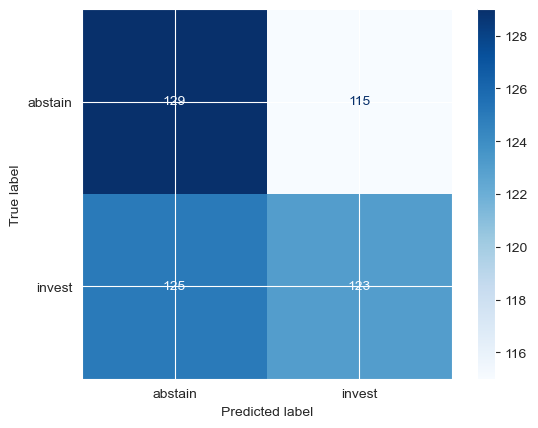

In [537]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()


# Results

1. Best model: KNN did the best as far as accuracy AND what we value most in a model. As you can see the KNN model is the only model that had more true positives (we invested when we should have invested) than false positives (we invested when we shouldnt have invested, thus losing money). Even though the other models were very close in terms of accuracy, none of the other models managed to have more true positives than false positives. Because of this fact, we have to declare that the KNN model is the superior one and may actually offer a return on investment.
2. In all honestly, I am very surprised that we were able to achieve a small percentage over 50/50. Its definitely better than a coin flip, and not only this, whats more important to our model and our domain is that we minimize the false positives above all else which KNN did. I am surprised since, this being a time series problem, that we werent able to contextualize each row to have enough data for the model to pick up any sort of relationships. Furthermore, we generated a lot of features from a small set of columns and even had to trim down those columns since they were so tightly correlated.
3. I think KNN did the best since it seems to mostly rely on distances/differences and our features that we generated were largely differences in changes of rate, volume, & 'acceleration' of a stock price. Since our other models did well, I think we can assume that we have a well balanced model and given more options and time to the GridSearchCV, it may even find hyperparameters that are better


As for our business, we can actually calculate a rough profit from the number of false positives and true positives

Assuming that each trade, we trade $X amount of dollars, we can find the cost of false positives to be in the worst case to be: $X * (115 - 115 * % decrease in stock) = $115X - $115X * decrease in stock
While, we can calculate a rough number for true positives to be: $X * (123 + 123 * % increase in stock) = $123X + 123X * increase in stock